### The purpose of this notebook to is to recreate the regress the SSH in GLORYS onto the CWI developed in Amaya et al. (2022)

In [1]:
import os
os.chdir('/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/scripts')
plotsdir = lambda x="": "/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/plots/" + x
GLORYS_dir = lambda x="": "/vortexfs1/home/anthony.meza/GLORYS_data" + x
GLORYS_data_dir = lambda x="": "/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/GLORYS_processed/" + x
ERA5_data_dir = lambda x="": "/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/ERA5_data/" + x

In [2]:
# from help_funcs import * 
# from eofs.xarray import Eof
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import importlib
import xarray as xr
import seaborn as sns
import pandas as pd
import cmocean.cm as cm
import netCDF4 as nc
import matplotlib.pyplot as plt
import gc
import os 
import multiprocessing
from os.path import exists
sns.set_context("notebook")
import dask_labextension
from pathlib import Path
import numpy as np
import dask
import pickle
# dask.config.set({"array.slicing.split_large_chunks": False})

In [3]:
def remove_climatology(ds, climatology):
    ds = ds.convert_calendar('noleap') #remove leap years from operations
    anomalies = ds.groupby("time.dayofyear") - climatology
    anomalies["time"] = anomalies.indexes['time'].to_datetimeindex()
    anomalies["time"] = anomalies.indexes['time'].normalize()
    return anomalies
def is_djf(month):
    return (month >= 1) & (month <= 2) | (month == 12)
def is_djfm(month):
    return (month >= 1) & (month <= 3) | (month == 12)
def is_jfm(month):
    return (month >= 1) & (month <= 3) 

### We read in the Amaya Coastal Wave Index Amplitude $(\text{Index} =  \sqrt{\text{PC1}^2 + \text{PC2}^2)}$ and Phase $(\text{Phase} = atan( {\frac{\text{PC2}}{\text{PC1}}}))$ and recompute $\text{PC1}$ and $\text{PC2}$. We also remove the leap-year days from the GLORYS dataset.

In [4]:
with open(GLORYS_data_dir("GLORYS_CoastalLocations.pickle"), 'rb') as handle:
    distance_labels = pickle.load(handle)

In [5]:
def get_phase_indices(INDEX_TYPE):

    mxtmp_Idx = xr.open_dataset(GLORYS_data_dir("GLORYS_" + INDEX_TYPE + "_Index.nc")).sel(time = slice("1993", "2018"))
    mxtmp_Idx["ikw_amp"] = np.sqrt(mxtmp_Idx["PC1"]**2 + mxtmp_Idx["PC2"]**2)

    #obtain the phases from 0 to 360 degrees
    #measure angle from negative (-1, 0) instead of (1, 0)
    mxtmp_Idx["ikw_ph"] =  np.rad2deg(np.arctan2(mxtmp_Idx["PC2"], mxtmp_Idx["PC1"]))
    mxtmp_Idx["ikw_ph"].values[mxtmp_Idx["ikw_ph"].values < 0] +=360
    
    mxtmp_Idx_djf = mxtmp_Idx.isel(time = is_djfm(mxtmp_Idx["time.month"])); min_amp = 1.0
    phases_dict = {}
    phases_dict["1"] = np.argwhere((45 > mxtmp_Idx_djf.ikw_ph.values) & (mxtmp_Idx_djf.ikw_ph.values >=0) & (mxtmp_Idx_djf.ikw_amp.values >min_amp) )
    phases_dict["2"] = np.argwhere((90 > mxtmp_Idx_djf.ikw_ph.values) & (mxtmp_Idx_djf.ikw_ph.values >=45) & (mxtmp_Idx_djf.ikw_amp.values >min_amp) )
    phases_dict["3"] = np.argwhere((135 > mxtmp_Idx_djf.ikw_ph.values) & (mxtmp_Idx_djf.ikw_ph.values >=90) & (mxtmp_Idx_djf.ikw_amp.values >min_amp) )
    phases_dict["4"] = np.argwhere((180 > mxtmp_Idx_djf.ikw_ph.values) & (mxtmp_Idx_djf.ikw_ph.values >=135) & (mxtmp_Idx_djf.ikw_amp.values >min_amp) )
    phases_dict["5"] = np.argwhere((225 > mxtmp_Idx_djf.ikw_ph.values) & (mxtmp_Idx_djf.ikw_ph.values >=180) & (mxtmp_Idx_djf.ikw_amp.values >min_amp) )
    phases_dict["6"] = np.argwhere((270 > mxtmp_Idx_djf.ikw_ph.values) & (mxtmp_Idx_djf.ikw_ph.values >=225) & (mxtmp_Idx_djf.ikw_amp.values >min_amp) )
    phases_dict["7"] = np.argwhere((315 > mxtmp_Idx_djf.ikw_ph.values) & (mxtmp_Idx_djf.ikw_ph.values >=270) & (mxtmp_Idx_djf.ikw_amp.values >min_amp) )
    phases_dict["8"] = np.argwhere((360 > mxtmp_Idx_djf.ikw_ph.values) & (mxtmp_Idx_djf.ikw_ph.values >=315) & (mxtmp_Idx_djf.ikw_amp.values >min_amp) )
    return mxtmp_Idx, phases_dict

def extract_phase_DJF(phases_dict, mxtmp_Idx):
    DJF_phases = {}
    var_keys = ["SST", "SSH"]
    for key in var_keys:
        DJF_phases[key] = {}
    anomalies_filtered_kandf = xr.open_dataset(GLORYS_data_dir("GLORYS_Coastal_Vars_Anomalies_SpaceTimeFiltered.nc")).sel(time = slice("1993", "2018"))
    print(len(anomalies_filtered_kandf.distance))
    #zero out the equator, only keep coastal points 
    coast_mask = anomalies_filtered_kandf.distance
    coast_mask = (coast_mask > distance_labels["SA"]).astype("int").values
    filtered_masked = anomalies_filtered_kandf.isel(distance = np.where(coast_mask)[0])
    print(len(filtered_masked.distance))

    filtered_masked["distance"] = filtered_masked["distance"] - filtered_masked.distance.values[0]
    xdistance_labels = {k:v -distance_labels["SA"]  for k, v in distance_labels.items()}
    
    for phase, phase_indices in phases_dict.items():    
        num_phases_days = len(phase_indices)
        sst_anom_mean = filtered_masked.thetao.isel(time = is_djfm(mxtmp_Idx["time.month"])).isel(time = phase_indices.flatten()).mean(dim = "time")
        ssh_anom_mean = filtered_masked.zos.isel(time = is_djfm(mxtmp_Idx["time.month"])).isel(time = phase_indices.flatten()).mean(dim = "time")

        DJF_phases["SST"][phase] = sst_anom_mean.compute()
        DJF_phases["SSH"][phase] = ssh_anom_mean.compute()
    return DJF_phases, xdistance_labels


In [6]:
hovmoller_ds = xr.open_dataset(GLORYS_data_dir("GLORYS_Coastal_Path.nc")).compute()
distances = hovmoller_ds.distance.values
findminlat = lambda lat, lat0: np.argmin((lat - lat0)**2)

In [7]:
# x = plt.xcorr(mxtmp_Idx.PC1, mxtmp_Idx.PC2, usevlines = Flase)
# plt.plot(x[0], x[1])

In [8]:
def combine_phases(var_phases, phases_dict):
    d = dict()
    ndays = dict()
    nphase_indices1 = len(phases_dict["1"])
    nphase_indices2 = len(phases_dict["8"])
    ndays["18"] = nphase_indices1 + nphase_indices2
    d["18"] = (var_phases["1"]*nphase_indices1 + var_phases["8"]*nphase_indices2) / ndays["18"]
    
    nphase_indices1 = len(phases_dict["2"])
    nphase_indices2 = len(phases_dict["3"])
    ndays["23"] = nphase_indices1 + nphase_indices2
    d["23"] = (var_phases["2"]*nphase_indices1 + var_phases["3"]*nphase_indices2) / ndays["23"]
      
    nphase_indices1 = len(phases_dict["4"])
    nphase_indices2 = len(phases_dict["5"])
    ndays["45"] = nphase_indices1 + nphase_indices2

    d["45"] = (var_phases["4"]*nphase_indices1 + var_phases["5"]*nphase_indices2) / ndays["45"]
    
    nphase_indices1 = len(phases_dict["6"])
    nphase_indices2 = len(phases_dict["7"])
    ndays["67"] = nphase_indices1 + nphase_indices2
    d["67"] = (var_phases["6"]*nphase_indices1 + var_phases["7"]*nphase_indices2) / ndays["67"]
    
    return d, ndays

In [9]:
mxtmp_Idx, phases_dict = get_phase_indices("S")
DJF_phases, xdistance_labels = extract_phase_DJF(phases_dict, mxtmp_Idx)

2204
1398


In [10]:
def plot_geovlines(labels_dict, ax):
    ax2 = ax.twiny()
    locs=[]
    labels = []
    ylims = ax.get_ylim()
    for (key, value) in labels_dict.items():
        ax2.axvline(value, c = "black", alpha = 0.3, zorder = 0, linestyle = "--")
        locs+=[value]
        labels+=[key]
    ax2.set_xticklabels(labels)
    ax2.set_xticks(locs)
    ax2.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1])
def plot_geovlines_nolabel(labels_dict, ax):
    ax2 = ax.twiny()
    locs=[]
    labels = []
    ylims = ax.get_ylim()
    for (key, value) in labels_dict.items():
        ax2.axvline(value, c = "black", alpha = 0.3, zorder = 0, linestyle = "--")
        locs+=[value]
        labels+=[""]
    ax2.set_xticklabels(labels)
    ax2.set_xticks(locs)
    ax2.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1])

2204
1398


/tmp/ipykernel_62762/3180130734.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(labels)
/tmp/ipykernel_62762/3180130734.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(labels)


2204
1398


/tmp/ipykernel_62762/3180130734.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(labels)
/tmp/ipykernel_62762/3180130734.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(labels)


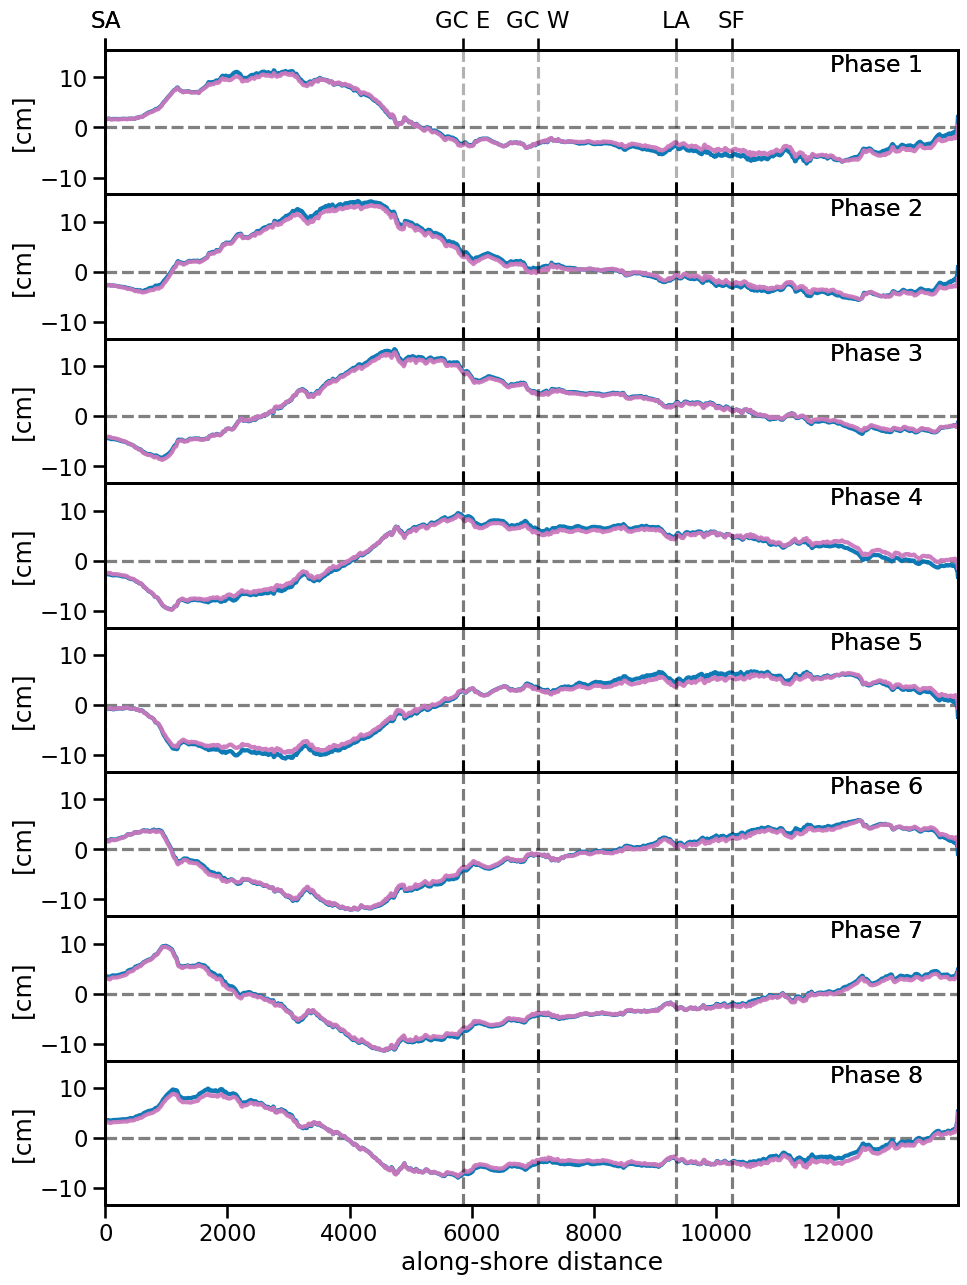

In [11]:
## Getting the $\pm$ 3 days view for phase 5
sns.set_context("talk")
fig, axes = plt.subplots(ncols = 1, nrows = 8, figsize = (11, 15), sharey = True, sharex = True)
colors = [sns.color_palette("colorblind")[i] for i in [4, 0]]
alphas = [0.95, 0.95]
linewidth = 3
label = ["SST/SSH Index", "SSH Index"]
zorders = [10, 1]
for (j, INDEX_TYPE) in enumerate(["SM", "S"]):
    mxtmp_Idx, phases_dict = get_phase_indices(INDEX_TYPE)
    DJF_phases, xdistance_labels = extract_phase_DJF(phases_dict, mxtmp_Idx)
    for phase, phase_indices in phases_dict.items():
        d = DJF_phases["SSH"][phase].distance.values
        nphase= len(phase_indices.flatten())
        phase_num = int(phase) - 1; i = phase_num
        axes[i].axhline(0, color = "grey", alpha = 0.95, zorder = 0, linestyle = "--")
        if i < 1:
            plot_geovlines(xdistance_labels, axes[i])
        else:
            plot_geovlines_nolabel(xdistance_labels, axes[i])
        axes[i].plot(d, 100 * DJF_phases["SSH"][phase], c= colors[j], 
                     label = label[j], alpha = alphas[j], linewidth = linewidth, zorder = zorders[j])
        phase_text= "Phase " + str(phase)
        axes[i].text(0.85, 0.85, phase_text, 
                     transform=axes[i].transAxes, fontsize = 17)
        axes[i].set_xlim(d.min(), d.max())
        # axes[i].set_ylim(-12.5, 12.5)
        axes[i].set_ylabel("[cm]")

fig.subplots_adjust(hspace=0)
axes[-1].set_xlabel("along-shore distance")
fig.savefig(plotsdir("generals/CoastalSSHComposites_Labeled.png"), bbox_inches = "tight")

2204
1398
2204
1398


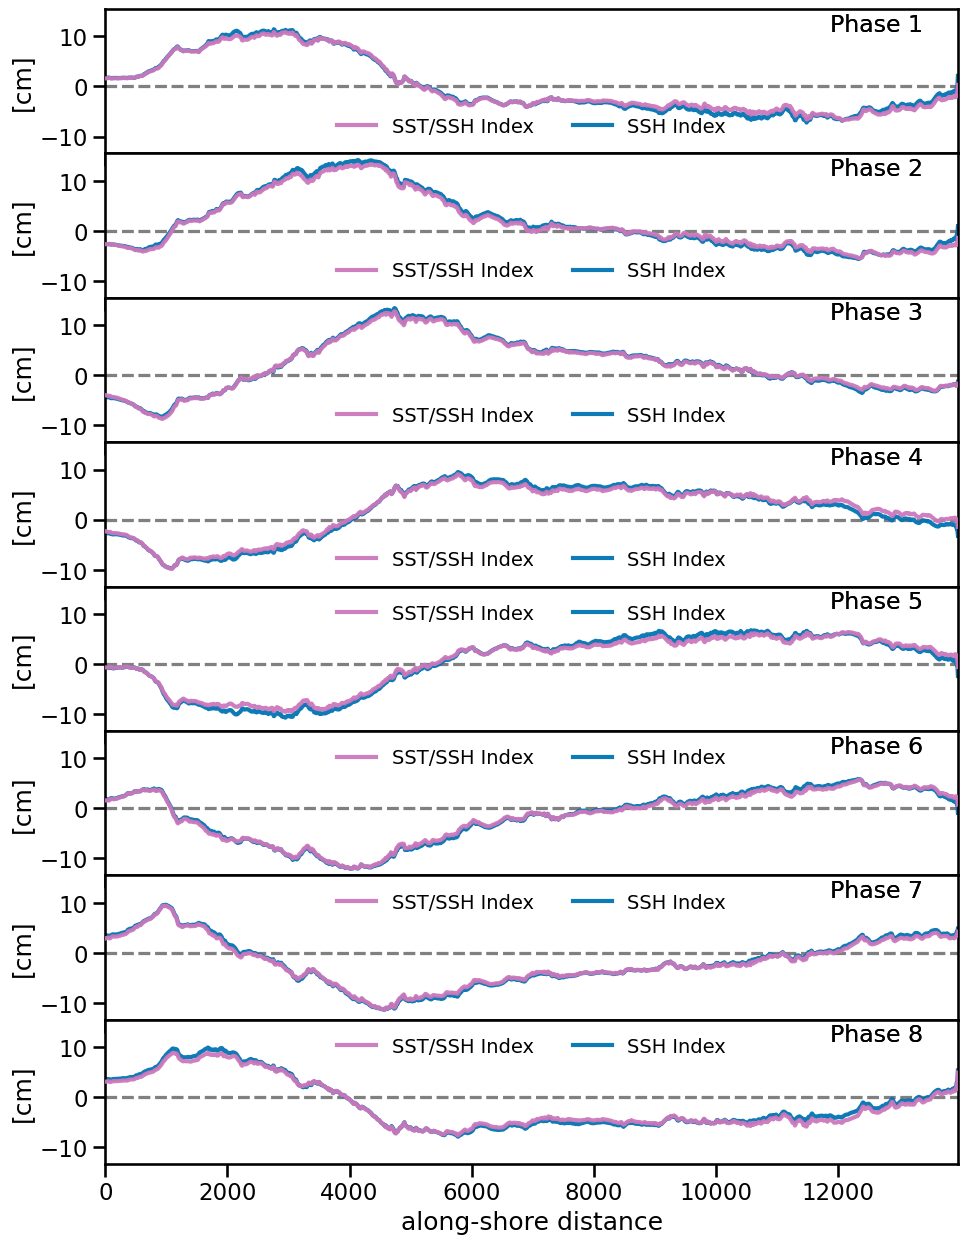

In [47]:
## Getting the $\pm$ 3 days view for phase 5
sns.set_context("talk")
fig, axes = plt.subplots(ncols = 1, nrows = 8, figsize = (11, 15), sharey = True, sharex = True)
colors = [sns.color_palette("colorblind")[i] for i in [4, 0]]
alphas = [0.95, 0.95]
linewidth = 3
label = ["SST/SSH Index", "SSH Index"]
zorders = [10, 1]
for (j, INDEX_TYPE) in enumerate(["SM", "S"]):
    mxtmp_Idx, phases_dict = get_phase_indices(INDEX_TYPE)
    DJF_phases, xdistance_labels = extract_phase_DJF(phases_dict, mxtmp_Idx)
    for phase, phase_indices in phases_dict.items():
        d = DJF_phases["SSH"][phase].distance.values
        nphase= len(phase_indices.flatten())
        phase_num = int(phase) - 1; i = phase_num
        axes[i].axhline(0, color = "grey", alpha = 0.95, zorder = 0, linestyle = "--")
        
        axes[i].plot(d, 100 * DJF_phases["SSH"][phase], c= colors[j], 
                     label = label[j], alpha = alphas[j], linewidth = linewidth, zorder = zorders[j])
        phase_text= "Phase " + str(phase)
        axes[i].text(0.85, 0.85, phase_text, 
                     transform=axes[i].transAxes, fontsize = 17)
        axes[i].set_xlim(d.min(), d.max())
        # axes[i].set_ylim(-12.5, 12.5)
        axes[i].set_ylabel("[cm]")

        if i < 4:
            
            axes[i].legend(loc ='lower center', ncols = 2, frameon=False, fontsize = 14, markerscale = 0.1)
        else:
            axes[i].legend(loc ='upper center', ncols = 2, frameon=False, fontsize = 14, markerscale = 0.1)
fig.subplots_adjust(hspace=0)
axes[-1].set_xlabel("along-shore distance")
fig.savefig(plotsdir("generals/CoastalSSHComposites_Legend.png"), bbox_inches = "tight")